# Isolation Forest

## Data preprocessing

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [19]:
df = pd.read_csv("hackathon_kpis_anonymised.csv")
df.head()

,cell_name,timestamp,ho_failure_rate,num_voice_attempts,voice_drop_rate,num_data_attempts,voice_setup_failure_rate,voice_tot_failure_rate,avail_period_duration,bandwidth,throughput_rate,data_setup_failure_rate,data_drop_rate,data_tot_failure_rate,unavail_total_rate,unavail_unplan_rate
0,00_11Z,2020-04-09 15:00:00+00:00,0.333333,0.000927,0.0,0.004527,0.0,0.0,1.0,0.49975,0.000195,0.000000,0.000731,0.000731,0.333364,0.0
1,00_11Z,2020-04-22 14:00:00+00:00,0.360000,0.017609,0.0,0.012312,0.0,0.0,1.0,0.49975,0.000197,0.001075,0.000269,0.000403,0.333364,0.0
2,00_11Z,2020-05-08 21:00:00+00:00,0.333333,0.002780,0.0,0.008115,0.0,0.0,1.0,0.49975,0.000196,0.000000,0.000000,0.000000,0.333364,0.0
3,00_11Z,2020-05-10 13:00:00+00:00,0.380952,0.012048,0.0,0.004898,0.0,0.0,1.0,0.49975,0.000116,0.000000,0.002027,0.002027,0.333364,0.0
4,00_11Z,2020-05-12 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.49975,NaN,NaN,NaN,NaN,0.666728,0.0


In [20]:
df.info()
df.groupby('cell_name')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042688 entries, 0 to 1042687
Data columns (total 16 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   cell_name                 1042688 non-null  object 
 1   timestamp                 1042688 non-null  object 
 2   ho_failure_rate           469309 non-null   float64
 3   num_voice_attempts        912315 non-null   float64
 4   voice_drop_rate           630066 non-null   float64
 5   num_data_attempts         912210 non-null   float64
 6   voice_setup_failure_rate  630066 non-null   float64
 7   voice_tot_failure_rate    630066 non-null   float64
 8   avail_period_duration     1042688 non-null  float64
 9   bandwidth                 1042688 non-null  float64
 10  throughput_rate           811369 non-null   float64
 11  data_setup_failure_rate   895247 non-null   float64
 12  data_drop_rate            895247 non-null   float64
 13  data_tot_failure_rate     8

In [22]:
nans_2 = {}
for key, val in nans.items():
  perc = val['total_nans']/val['num_timesteps']
  if perc < 0.15:
    nans_2[key] = perc

nans_2

{'07_31R': 0.13588588588588588}

In [23]:
def get_cell_df(cell_name):
  return df[df['cell_name'] == cell_name]

In [24]:
def preprocess(df):
  df_temp = df.fillna(df.median(), axis='index')
  df_temp = df_temp.drop(columns='cell_name')
  df_temp = df_temp.sort_values('timestamp')
  return df_temp.set_index('timestamp')

In [25]:
def dont_use_df(df):
  # skip this df if a whole column is nan
  return df.isna().sum().sum() > 0

In [26]:
def add_aggregated_time_information(data, window_size=5):
  time = np.zeros(shape=data.shape)
  for i in range(window_size, time.shape[0]):
    time[i] = np.mean(data[i-window_size:i], axis=0)

  return np.concatenate((data, time), axis=1)

## Isolation forest

In [34]:
skipped = []
scores_per_cell = {}
for cell in df['cell_name'].unique():
  df_temp = get_cell_df(cell)
  df_temp = preprocess(df_temp)
  if dont_use_df(df_temp):
    skipped.append(cell)
    continue
  pca = PCA(n_components=8)
  data = pca.fit_transform(df_temp)
  data = add_aggregated_time_information(data)
  model =  IsolationForest(contamination = 0.1, random_state=42)
  model.fit(data)
  scores_per_cell[cell] = {'score':model.score_samples(data), 'timestep':df_temp.index} # Low = abnormal

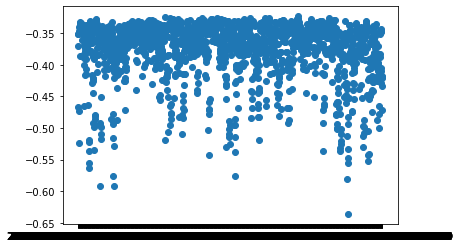

In [39]:
cell_name_to_plot = df['cell_name'].unique()[5]
plt.scatter(scores_per_cell[cell_name_to_plot]['timestep'], scores_per_cell[cell_name_to_plot]['score'])
plt.show()